# O mercado imobiliário em 2020 
### Apartamentos/Fortaleza-CE
---

* **[Link para visualização do notebook pelo NBViewer: (necessário para visualização dos gráficos)](https://nbviewer.jupyter.org/github/andrepombo/Portfolio/blob/master/Imoveis4.ipynb)**

### Introduçāo

O ano de 2019 vinha dando sinais de melhora para o mercado imobiliário mas a pandemia mundial **COVID-19** que deu seus primeiros sinais por terras alencarinas em março, pegou todos de surpresa. Apesar dos recordes nos cortes das taxas de juros, a recessão econômica fez com que o consumidor se desmonstrasse cauteloso em relação a novas despesas, principalmente aquelas que comprometem uma fatia relevante de sua renda. 

Há também quem diga que uma possível nova tendencia surja entre novos compradores, a de maior valorizacao de imoveis com grandes varandas ou ate mesmo a preferencia por casas com seus enormes quintais.

Diante disso, decidi dar uma olhada mais de perto nos apartamentos disponíveis para venda na cidade, e verificar de fato como esta o mercado, com o objetivo de responder algumas perguntas:

1. Como é o comportamento da distribuição de preços dos imóveis disponíveis para venda?
2. Quais são as regiões mais valorizadas da cidade?
3. Somos capazes de prever o preço de venda dos apartamentos?

Dividi minha abordagem nos passos abaixo:
    
* **Coleta de dados**: Utilizando web scrapping no Python, extrai os dados referentes aos preços de venda de alguns sites.
* **Limpeza de dados**: Essa é geralmente a parte mais demorada de qualquer processo de análise de dados. Neste caso, é essencial fazer a limpeza do Dataset para que seja possível formatar os dados, remover outliers etc.
* **Análise Exploratória (EDA)**: A análise exploratória de dados é importante para o entendimento dos dados e para se ter uma visão geral do dataset.
* **Análise Preditiva**: Neste passo eu criei, treinei e unidosi um modelo de machine learning para o dataset com o objetivo de realizar a predição do preço de venda de imóveis em Fortaleza.
* **Feature Engineering**: Em busca de um modelo mais robusto, fiz transformações nos dados e inclui novas features baseadas em dados geográficos

### Limpeza de dados

In [54]:
import pandas as pd
import numpy as np

pd.set_option('display.max_colwidth', 400)
pd.set_option('display.min_rows', 100)

In [55]:
df = pd.read_csv('imoveis_junho.csv')
df.shape

(3120, 7)

Como resultado do nosso primeiro passo “Coleta de dados”, extraímos um dataset contendo 3120 apartamentos para venda em junho de 2020 no formato “.csv”.

In [56]:
df.head()

,price,area_m2,bedrooms,bathrooms,vagas,endereco,description
0,3196671,209 - 259,4,4,4 - 5,"Avenida Coronel Miguel Dias, Guararapes","O Cosmopolitan não é apenas um lugar para morar. É um novo e exclusivo estilo de vida. Localizado no melhor do Guararapes, ele oferece mais de 7mil m² de área de lazer, que proporc..."
1,355000,48 - 68,2 - 3,2,1 - 2,"Rua Senador Pompeu, Fátima","Localização: Rua Senador Pompeu, 2610 - Fátima, Fortaleza - CE.Comece a pagar seu financiamento daqui a 6 mesesFaça já o tour virtual 360° no empreendimento e compre 10..."
2,294500,53 - 114,2 - 4,1,1 - 3,"Rua Senador Pompeu, José Bonifácio","18 Pavimentos, sendo:2 Subsolos + Térreo + Mezanino + 13 Pavimentos Tipo + 4 Coberturas;112 Apartamentos;2 Elevadores;Localização privilegiada (UFC, Farias Brito, B..."
3,580000,92,3,3,2,"Joaquim Tavora, Fortaleza","Excelente apartamento no Joaquim Távora, área privativa de 92 m², todo projetado por arquiteto renomado, projeto de iluminacao com lampadas embutidas, sancas e lustre na sala, com..."
4,400000,78,2,3,2,"Travessa Beni Carvalho, Aldeota",Apartamento muito bem conservado e todo projetado (móveis Criare); - Excelente localização; - 3 centrais de ar-condicionado (sendo 1 em cada quarto e uma de 30.000 btus na sala); -...


Algumas linhas possuem mais de um numero por entrada. Nosso modelo mais adiante nao consegue lidar com tais situacoes, por isso iremos exclui-los. 

Alguns apartamentos tambem nao possuem preço declarado no dataset e tambem iremos exclui-los.

In [57]:
df = df[(df['vagas'].str.len() <=3 ) & (df['area_m2'].str.len() <= 3) & (df['bedrooms'].str.len() <= 3) & (df['price'] != 'Sob consulta')]
print(df.shape)

(3072, 7)


Algumas linhas possuem entradas ausentes. Por serem poucas e por nao atrapalharem os fins desse estudo iremos remove-las.

In [58]:
print(df.shape)
df.isnull().sum()

(3072, 7)


price           0
area_m2         0
bedrooms        0
bathrooms       3
vagas           0
endereco        0
description    62
dtype: int64

In [59]:
df = df.dropna(subset=['bathrooms'])
print(df.shape)

(3069, 7)


Nosso dataset agora possui 3069 ofertas de apartamentos para venda. Iremos entao analisar as variáveis e o formato dos dados.

In [60]:
df.dtypes

price          object
area_m2        object
bedrooms       object
bathrooms      object
vagas          object
endereco       object
description    object
dtype: object

Conseguimos verificar que apesar de algumas colunas claramente se apresentarem como numeros, estes nao sao entendidos pelo computador como tal. Por isso precisamos entao transformar tais colunas para um formato com que o computador possa reconhecer.

In [61]:
df[['price','area_m2','bedrooms','bathrooms','vagas']] = df[['price','area_m2','bedrooms','bathrooms','vagas']].astype(int)

In [62]:
df.describe()

,price,area_m2,bedrooms,bathrooms,vagas
count,3.069000e+03,3069.000000,3069.000000,3069.000000,3069.000000
mean,4.555108e+05,95.447377,2.903877,2.713913,1.848485
std,2.051255e+05,34.939670,0.550762,1.030629,0.700751
min,9.600000e+04,36.000000,1.000000,1.000000,1.000000
25%,2.950000e+05,70.000000,3.000000,2.000000,1.000000
50%,4.499990e+05,88.000000,3.000000,3.000000,2.000000
75%,5.883000e+05,116.000000,3.000000,3.000000,2.000000
max,2.000000e+06,364.000000,15.000000,12.000000,15.000000


O quadro acima apresenta medidas da estatística descritiva para cada uma das variáveis extraídas. São elas a quantidade (count), a média (mean), o desvio-padrão (std), valores mínimo (min) e máximo (max) e as marcações dos quartis (25, 50 e 75%). Podemos ver no quadro alguns numeros no minimo curiosos, como as maximas para quartos, banheiros e vagas que estao bem acima do que um apartamento normal teria e por isso provavelmente errados.

Diante disso resolvemos retirar quaisquer apartamentos que tivessem qualquer um desses 3 itens acima de 7.

In [63]:
df = df[(df.bedrooms <= 7) & (df.bathrooms <= 7) & (df.vagas <= 7)]
print(df.shape)

(3063, 7)


Aqui iremos criar mais uma coluna denominada 'price/m2' para fazermos melhores comparacoes de preco entre um apartamento e outro, e posteriormente calcular o preco do metro quadrado geral da cidade e por bairros.

In [64]:
df['price/m2'] = df['price'] / df['area_m2']
df['price/m2'] = df['price/m2'].round(2)

In [65]:
print(df.shape)
df.sort_values(by='price/m2', ascending=False).tail(10)

(3063, 8)


,price,area_m2,bedrooms,bathrooms,vagas,endereco,description,price/m2
2047,175000,124,3,3,1,"Avenida Heróis do Acre, Passaré","Apartamento com 123,80 m² de área construída;03 quartos, sendo 01 suíte;01 closet;01 banheiro social;Sala de estar e jantar;Cozinha;Área de serviço; -",1411.29
1751,175000,124,3,2,1,"Avenida Heróis do Acre, Passaré","Apartamento no Edifícil Passaré II, melhor localização do Passaré, vizinho ao BNB- 124 m²;- Sala com Varanda;- Cozinha Americana e Área de Serviço projetada com armário...",1411.29
35,190000,140,3,4,2,"Cocó, Fortaleza","Apartamento com localização Privilegiada, próximo ao Iguatemi, Parque do Cocó, Colégios Christus, Ari de Sá, 7 de Setembro, Comunidade Católica Face de Cristo e Parque do Cocó.Marc...",1357.14
181,230000,170,3,2,2,"Aerolândia, Fortaleza","Apartamento tipo cobertura com 170 m² de área construída, com amplo terraço privativo, ampla sala para 2 ambientes, 3 quartos, sendo 1 suíte, banheiro social, cozinha convencional....",1352.94
345,230000,170,3,2,2,"Aerolândia, Fortaleza","Apartamento tipo cobertura com 170 m² de área construída, com amplo terraço privativo, ampla sala para 2 ambientes, 3 quartos, sendo 1 suíte, banheiro social, cozinha convencional....",1352.94
11,190000,147,3,3,1,"Rua Ildefonso Albano, Joaquim Tavora","APARTAMENTO PRÓXIMO AO COLÉGIO MARIA ESTER, SÃO TRÊS QUARTOS, SENDO UMA SUÍTE, BANHEIRO SOCIAL, COZINHA, ÁREA DE SERVIÇO E DCE.",1292.52
2486,299000,250,4,4,2,"Rua Valdetário Mota, Papicu","Ótimo apartamento com 250 m² de área sendo 4 quartos (2 suítes), sala para 3 ambientes, estar intimo, escritório e sala de televisão, cozinha, dependência completa de empregada e v...",1196.00
793,270000,266,5,4,2,"Rua Doutor Manoel Rodrigues Monteiro, Praia do Futuro II","Apartamento 5 quartos, 1 por andar, com belíssima vista panorâmica para a Praia do Futuro.- 3 suítes, maior com closet (a dependência foi invertida e transformada em 1 quarto)- sal...",1015.04
114,310000,355,1,1,1,"Rua Antônio Atualpa Rodrigues, Antônio Diogo","1 VAGAS GARAGEM, 1 SUÍTES,SALA,COZINHA, CONDOMINIO 0,PISCINA EM CONDOMINIO,SALAO DE FESTAS EM CONDOMINIO, 1 VAGAS GARAGEM EM CONDOMINIO",873.24
149,199000,343,3,2,4,"Rua Morada Nova, Jangurussu","Casa Duplex em Messejana com uma área privativa de 343,20m²;, sendo 90m²; de área construída.- sala- 3 quartos (1 suíte)- cozinha- banheiroLocalizada próximo ao Campo do Curitiba,...",580.17


In [66]:
#df = df[(df['price/m2'] > 1000)]

Se prestarmos mais atencao ao dataset poderemos observar itens duplicados, e assim tambem iremos remove-los.

In [67]:
print('Quantidade de dados duplicados: ', df.duplicated().sum())
df.drop_duplicates(inplace=True)
print('Quantidade de dados duplicados após remoção: ', df.duplicated().sum())
print(df.shape)

Quantidade de dados duplicados:  304
Quantidade de dados duplicados após remoção:  0
(2759, 8)


Vamos agora criar apartir da coluna endereco duas novas colunas chamadas Rua e Bairro.

In [68]:
df['Bairro'] = df['endereco'].apply(lambda x: x.split(',')[1] if any(s in x.split()[0] for s in ("Rua","Avenida","Travessa","Alameda")) else x.split(',')[0])    

Para questoes de analise, a coluna descricao nao nos possui nenhum valor nesse estudo, por isso iremos remove-la.

In [69]:
df2 = df.drop(['description','endereco'], axis=1)

In [70]:
print(df2.shape)
df2.head()

(2759, 7)


,price,area_m2,bedrooms,bathrooms,vagas,price/m2,Bairro
3,580000,92,3,3,2,6304.35,Joaquim Tavora
4,400000,78,2,3,2,5128.21,Aldeota
5,550000,90,3,3,2,6111.11,Fortaleza
6,529000,77,3,2,2,6870.13,Meireles
7,550000,158,4,2,2,3481.01,Cocó


Alguns bairros ficaram erroneamente colocados como Fortaleza devido a incongruencias no endereco de origem, iremos entao remove-los.

In [71]:
df2['Bairro'] = df2['Bairro'].apply(lambda x: x.strip())
#df2['Bairro'] = df2['Bairro'].str.title()
df2 = df2[df2['Bairro'] != 'Fortaleza']

A lista de bairros fornecidos pela prefeitura não possui acentos e está com os nomes em maiusculas, alem de alguns bairros estarem com nomes ligeiramente diferentes. Iremos corrigir isso e igualar as duas listas para podermos realizar algumas analises mais a frente.

In [72]:
from unidecode import unidecode
df2["Bairro"]= df2["Bairro"].apply(lambda x: unidecode(x))
df2["Bairro"] = df2["Bairro"].str.upper()

In [73]:
df2["Bairro"] = df2["Bairro"].map(lambda x: x.replace("PREFEITO JOSE WALTER", "PREFEITO JOSE VALTER").replace("MANOEL DIAS BRANCO", "MANUEL DIAS BRANCO").replace("ENGENHEIRO LUCIANO CAVALCANTE","ENG LUCIANO CAVALCANTE").replace("SAPIRANGA","SAPIRANGA COITE").replace("GUARARAPES", "PATRIOLINO RIBEIRO"))

### Análise Exploratória (EDA)

Após a limpeza dos dados é hora de tentar responder algumas perguntas.

Fortaleza possui 121 bairros no total, do quais 93 estao presentes no dataset. Para termos analises de preco mais condizentes com a realidade, decidi optar apenas por bairros que possuem mais do que 6 ofertas de vendas, totalizando 47 bairros.

In [74]:
print(df2.shape)
a = len(df2['Bairro'].value_counts())
print(f'Numero de bairros presentes no dataset: {a}.') 
b = 7
bairros6 = df2['Bairro'].value_counts().loc[lambda x : x>=b]
print(f'Numero de bairros com {b} ou mais anuncios: {len(bairros6)}')

(2659, 7)
Numero de bairros presentes no dataset: 93.
Numero de bairros com 7 ou mais anuncios: 47


Numero de bairros com mais de 7 anuncios: 47


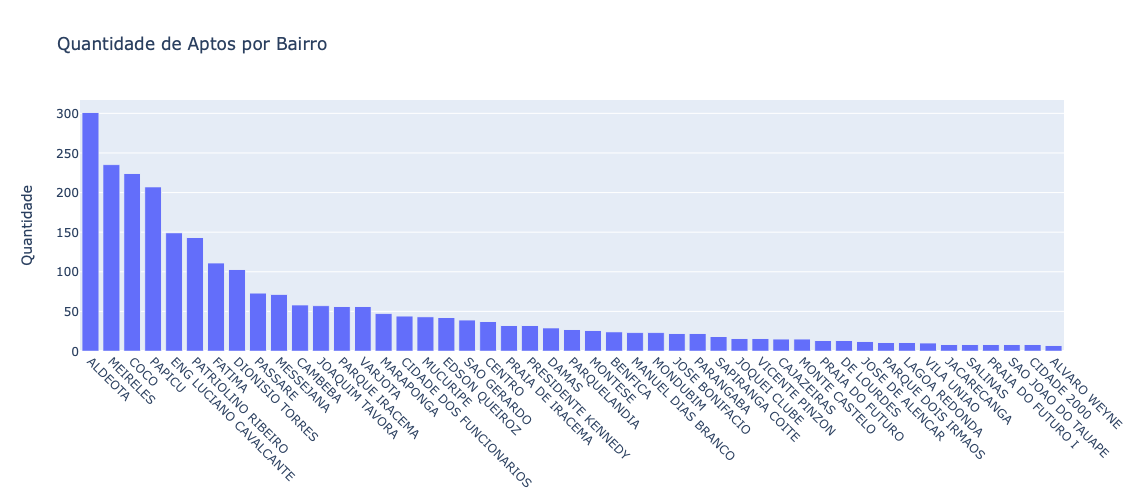

In [75]:
import plotly.offline as py
import plotly.graph_objs as go


x=bairros6.index
y=bairros6.values

print(f'Numero de bairros com mais de {b} anuncios: {len(x)}')

data = [go.Bar(x=x, y=y
            )]

layout = go.Layout(title = 'Quantidade de Aptos por Bairro',
                   #xaxis = {'title': 'Bairro'},
                   yaxis = {'title': 'Quantidade'},
                   height =500,
                   xaxis_tickangle=45
                   )
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stacked-bar')
c = len(x)

In [76]:
df_47 = df2[(df2['Bairro'].isin(list(bairros6.index)))]
print(df2.shape)
print(df_47.shape)
print(f'Numero de aptos cortados: {len(df2) - len(df_47)}')

(2659, 7)
(2553, 7)
Numero de aptos cortados: 106


Nós já temos algumas informacoes sobre quartis, minimos, maximas e medias para a maioria dos valores de nossas variaveis. Entretanto para uma analise mais visual, iremos gerar um **box plot**.

47


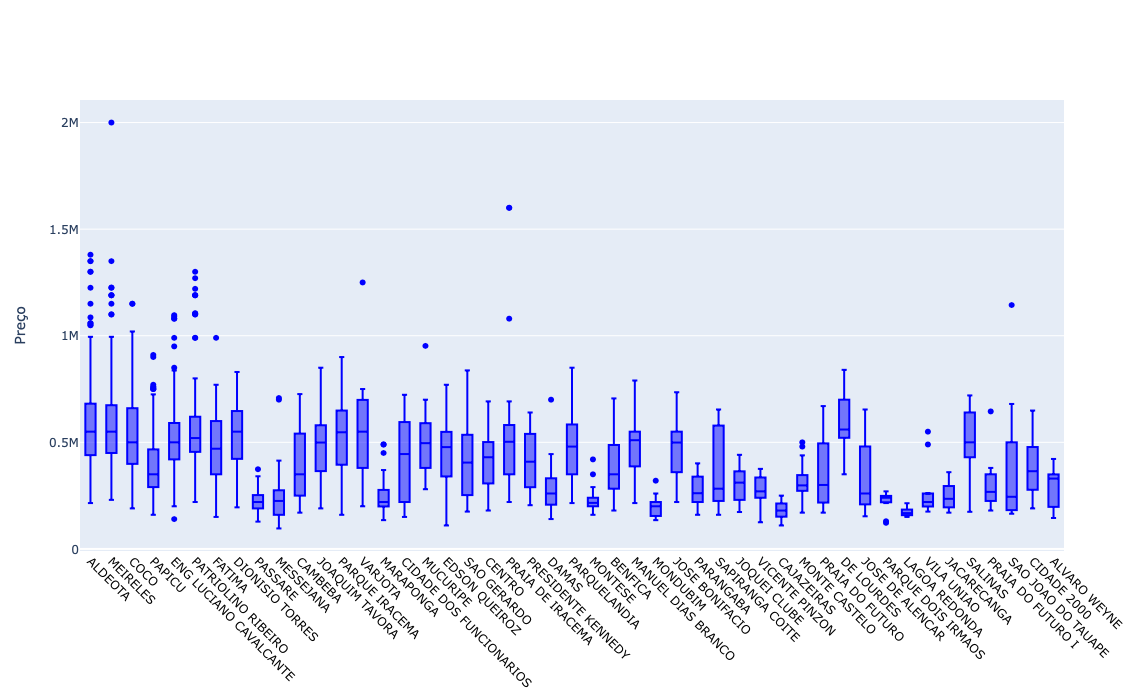

In [77]:
lista = bairros6.index.tolist()

trace1 = go.Box(
    y=df_47.price,
    x=df_47.Bairro,
    #name='kale',
    marker=dict(
        color='blue'
    )
)
data = [trace1]
layout = go.Layout(
       #title = 'Quantidade de Aptos por Bairro',
       yaxis = {'title': 'Preço'},
       barmode='stack',
       height = 700,
       xaxis=dict(
       categoryorder='array',
       categoryarray=lista,
       titlefont=dict(
         size=6,
         color='black'),
       showticklabels=True,
       tickfont=dict(
        size=12,
        color='black',
        ),
    tickangle=45,
   
    ),
)   
print (len(lista))
fig = go.Figure(data=data, layout=layout)
fig.show()

Como podemos ver temos uma grande quantidade de *outliers* - especialmente para apartamentos nos bairros Aldeota,Meireles,Eng Luciano Cavalcante e Patriolino Ribeiro. 

Vamos Reduzir a quantidade de *outliers* criando um subgrupo de nossos dados - um bom limite de corte para o preço de vendas poderia ser R$ 1M. 

In [78]:
df_47 = df_47[(df_47['price'] < 1100000)]
df_47.shape

(2520, 7)

47


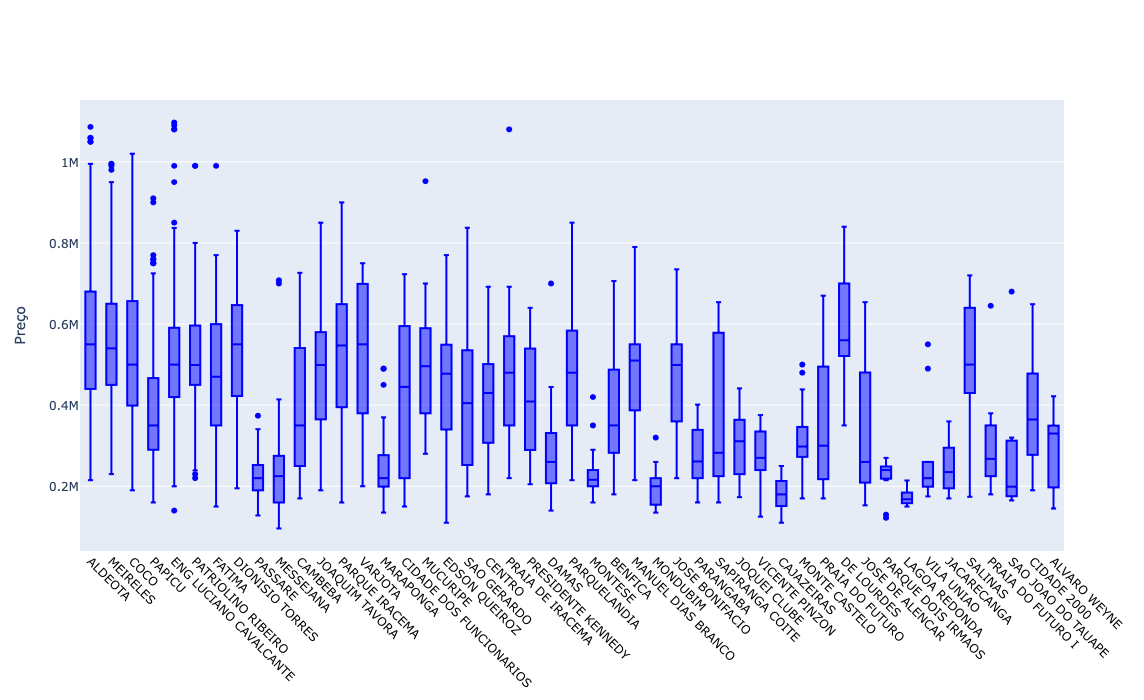

In [79]:
lista = bairros6.index.tolist()

trace1 = go.Box(
    y=df_47.price,
    x=df_47.Bairro,
    #name='kale',
    marker=dict(
        color='blue'
    )
)
data = [trace1]
layout = go.Layout(
       yaxis = {'title': 'Preço'},
       barmode='stack',
       height = 700,
       xaxis=dict(
       categoryorder='array',
       categoryarray=lista,
       titlefont=dict(
         size=6,
         color='black'),
       showticklabels=True,
       tickfont=dict(
        size=12,
        color='black',
        ),
    tickangle=45,
   
    ),
)   
print (len(lista))
fig = go.Figure(data=data, layout=layout)
fig.show()

Nós fomos capazes de remover a maioria dos *outliers*, e aqui já conseguimos observar a grande disparidade de preços entre bairros na cidade de Fortaleza.

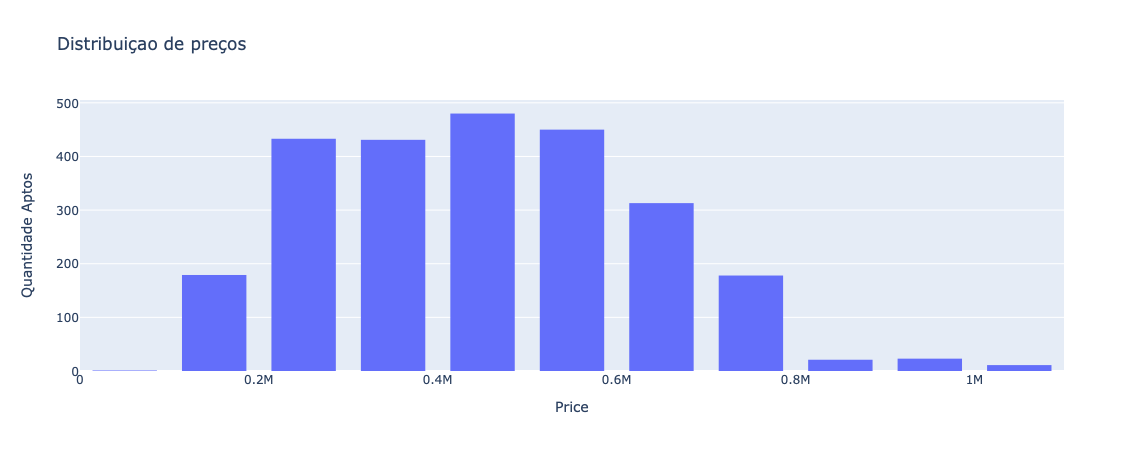

In [80]:
trace1 = go.Histogram(x=df_47['price'], nbinsx=20, name= 'Hist. Original')

fig = go.Figure()

fig.add_trace(trace1)

fig.update_layout(
    title_text='Distribuiçao de preços', # title of plot
    xaxis_title_text='Price', # xaxis label
    yaxis_title_text='Quantidade Aptos', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1 # gap between bars of the same location coordinates
)
fig.show()

In [81]:
print("Skewness: %f" % df_47['price'].skew())
print("Kurtosis: %f" % df_47['price'].kurt())

Skewness: 0.346813
Kurtosis: -0.277131


Qual tipo de apartamento mais comum em Fortaleza?

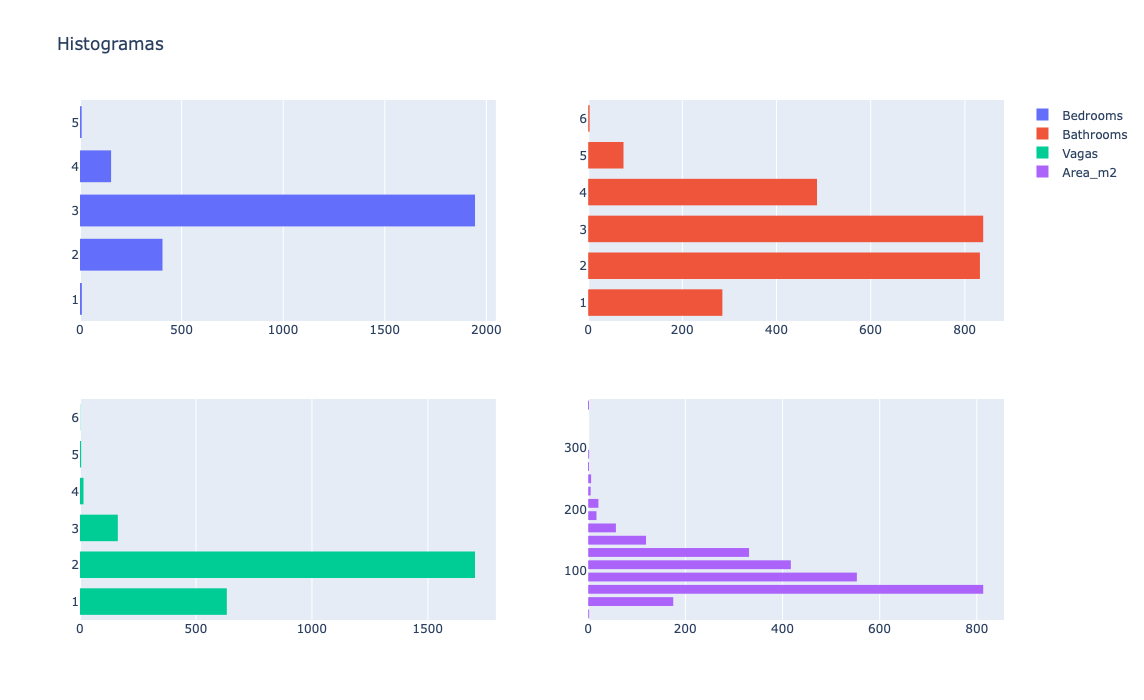

In [82]:
import plotly.offline as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Plotando Boxplot
y1 = df_47.bedrooms
y2 = df_47.bathrooms
y3 = df_47.vagas
y4 = df_47.area_m2

fig = make_subplots(rows=2, cols=2,) #subplot_titles=("Scores", "Magnitudes"))

fig.add_trace(go.Histogram(y=y1, name='Bedrooms'), row=1, col=1)
fig.add_trace(go.Histogram(y=y2, name='Bathrooms'), row=1, col=2)
fig.add_trace(go.Histogram(y=y3, name='Vagas'), row=2, col=1)
fig.add_trace(go.Histogram(y=y4, name='Area_m2', nbinsy=20), row=2, col=2)

fig.update_layout(height=700,  title_text="Histogramas", title_x =0.05)
fig.update_layout(
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1 # gap between bars of the same location coordinates
)
fig.show()

Conseguimos observar atraves dos histogramas que nosso dataset possui majoritariamente apartamentos entre 60 - 79 m2, com 3 quartos, entre 2 e 3 banheiros e 2 vagas.

Iremos agora realizar uma analise mais detalhada e obter a média para cada uma de nossas variaveis por bairro, mais a quantidade de apartamentos a venda por bairro.

In [83]:
bairros = df_47.groupby("Bairro").mean()

In [84]:
bairros['Number Aptos'] = bairros.index.map(bairros6)
bairros.dropna(subset=['Number Aptos'], inplace=True)
bairros['NOME']=bairros.index
bairros = bairros.round(2)
bairros = bairros.sort_values(by='price/m2', ascending=False)
bairros.head()

,price,area_m2,bedrooms,bathrooms,vagas,price/m2,Number Aptos,NOME
Bairro,,,,,,,,
ENG LUCIANO CAVALCANTE,526348.62,84.22,2.97,2.67,2.07,6266.09,149,ENG LUCIANO CAVALCANTE
PRAIA DE IRACEMA,486143.13,81.27,2.43,2.20,1.60,6171.26,32,PRAIA DE IRACEMA
MUCURIPE,494978.86,83.95,2.37,2.51,1.79,5998.22,43,MUCURIPE
MANUEL DIAS BRANCO,504649.17,85.61,2.70,2.91,1.91,5973.24,23,MANUEL DIAS BRANCO
PATRIOLINO RIBEIRO,519440.86,90.29,2.99,3.00,2.13,5924.53,143,PATRIOLINO RIBEIRO


O próximo grafico mostra de uma maneira bem didatica os bairros com as médias de precos mais caras em ordem descrente ate os mais baratos, assim como o número de apartamentos que ajudaram a compor esta média.

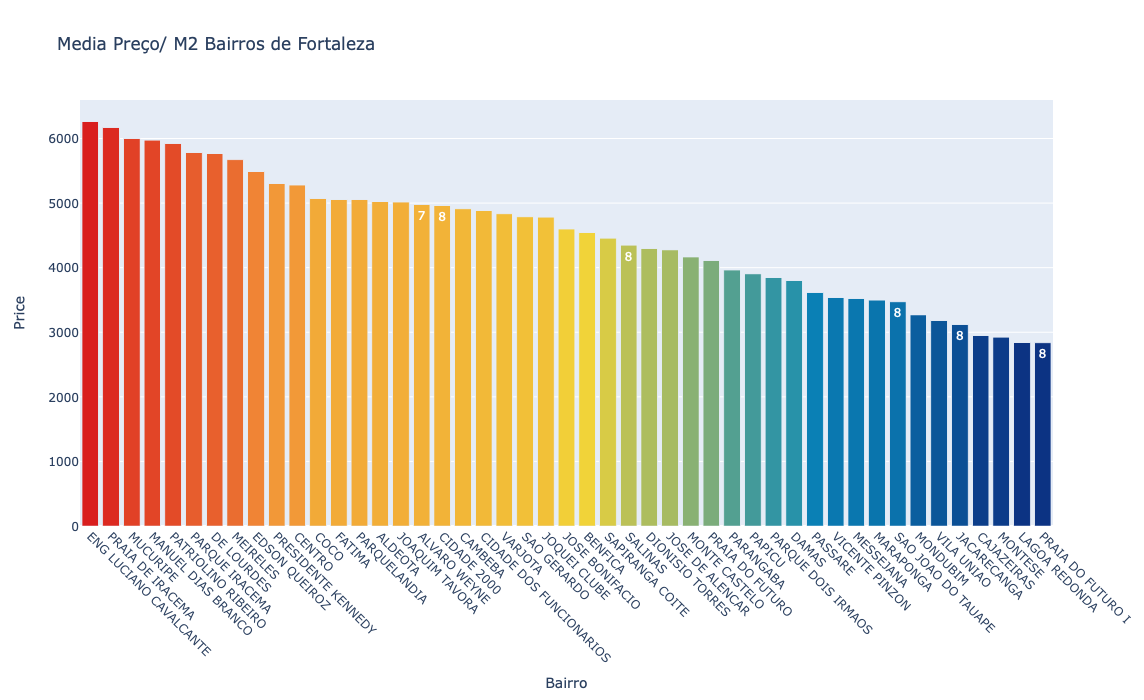

In [85]:
t = bairros['Number Aptos']
y = bairros['price/m2']
x = bairros.index

trace1 = go.Bar(y = y,
               x = x,
               marker={'color': y,'colorscale': 'Portland', 'reversescale': False}, 
               text= t, 
               textposition='auto',
               name='media')
              
data = [trace1]
layout = go.Layout(title = 'Media Preço/ M2 Bairros de Fortaleza',
                   xaxis = {'title': 'Bairro'},
                   yaxis = {'title': 'Price'},
                   height = 700,
                   uniformtext_minsize=9,
                   uniformtext_mode='hide',
                   xaxis_tickangle=45                 
                   )
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

[Text(0.5, 0, 'price'),
 Text(1.5, 0, 'area_m2'),
 Text(2.5, 0, 'bedrooms'),
 Text(3.5, 0, 'bathrooms'),
 Text(4.5, 0, 'vagas'),
 Text(5.5, 0, 'price/m2')]

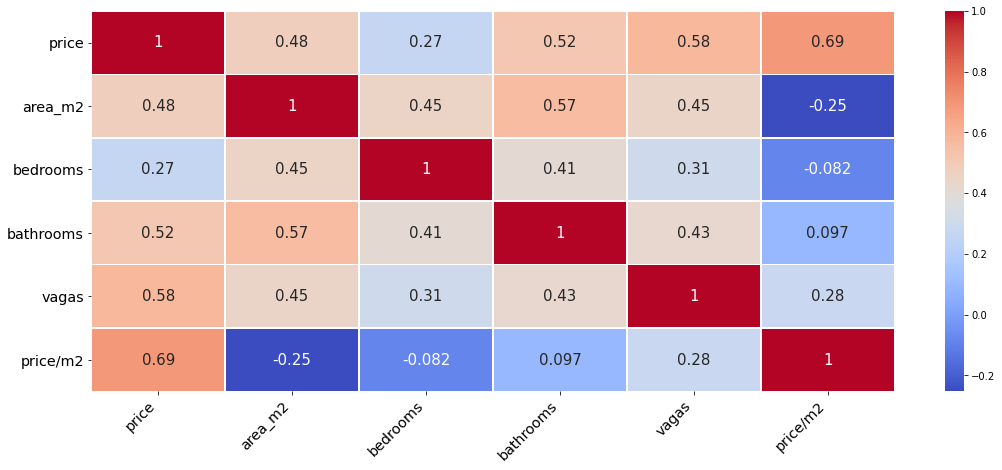

In [86]:
import seaborn as sns
import matplotlib.pyplot  as plt
%matplotlib inline
# Gerar dataframe de correlações
z = df_47.corr()

# Plotar heatmap
plt.figure(figsize=(18,7))
g = sns.heatmap(z, cmap='coolwarm', linewidths=0.5, annot=True,annot_kws={"size": 15})
g.set_yticklabels(g.get_yticklabels(), rotation=0, horizontalalignment='right', fontsize='x-large')
g.set_xticklabels(g.get_yticklabels(), rotation=45, horizontalalignment='right', fontsize='x-large')

In [87]:
import json
import geopandas as gpd

data = json.load(open('FortalezaBairros.geojson'))

mapa_bairros = gpd.GeoDataFrame.from_features(data,crs="epsg:4326")

In [88]:
mapa_bairros= mapa_bairros[['GID', 'NOME','geometry']]

In [89]:
unidos = pd.merge(mapa_bairros, bairros, on='NOME', how='inner')
print(len(unidos))
unidos = unidos[unidos['Number Aptos'] >=3]
unidos= unidos[['GID', 'NOME','price','area_m2', 'bedrooms', 'bathrooms', 'vagas', 'price/m2', 'Number Aptos','geometry']]
unidos.sort_values(by='price/m2', ascending=False).head(3)

46


,GID,NOME,price,area_m2,bedrooms,bathrooms,vagas,price/m2,Number Aptos,geometry
12,27,ENG LUCIANO CAVALCANTE,526348.62,84.22,2.97,2.67,2.07,6266.09,149,"POLYGON ((-38.48243 -3.76650, -38.48242 -3.76663, -38.48235 -3.76754, -38.48233 -3.76772, -38.48230 -3.76806, -38.48228 -3.76835, -38.48221 -3.76920, -38.48219 -3.76942, -38.48213 -3.77021, -38.48211 -3.77046, -38.48203 -3.77133, -38.48202 -3.77154, -38.48200 -3.77175, -38.48197 -3.77220, -38.48191 -3.77289, -38.48162 -3.77645, -38.48143 -3.77841, -38.48129 -3.78009, -38.48121 -3.78103, -38.48..."
44,113,PRAIA DE IRACEMA,486143.13,81.27,2.43,2.20,1.60,6171.26,32,"POLYGON ((-38.51262 -3.72401, -38.51311 -3.72398, -38.51378 -3.72393, -38.51386 -3.72393, -38.51405 -3.72391, -38.51492 -3.72386, -38.51576 -3.72380, -38.51615 -3.72377, -38.51741 -3.72370, -38.51800 -3.72366, -38.51943 -3.72355, -38.51932 -3.72249, -38.51932 -3.72150, -38.51933 -3.72101, -38.51934 -3.72075, -38.51954 -3.72078, -38.51979 -3.72082, -38.51990 -3.72084, -38.51990 -3.72035, -38.51..."
37,104,MUCURIPE,494978.86,83.95,2.37,2.51,1.79,5998.22,43,"POLYGON ((-38.48988 -3.72325, -38.48986 -3.72321, -38.48984 -3.72317, -38.48983 -3.72314, -38.48980 -3.72313, -38.48976 -3.72315, -38.48972 -3.72316, -38.48969 -3.72317, -38.48966 -3.72317, -38.48966 -3.72314, -38.48968 -3.72313, -38.48967 -3.72310, -38.48967 -3.72307, -38.48963 -3.72308, -38.48960 -3.72309, -38.48956 -3.72307, -38.48952 -3.72306, -38.48948 -3.72307, -38.48946 -3.72309, -38.48..."


In [90]:
mapa_bairros2 = pd.merge(mapa_bairros, bairros, on='NOME', how='outer')

In [91]:
dropar = set(bairros.NOME).symmetric_difference(unidos.NOME)
print(f'Bairros fora da lista da prefeitura: {len(dropar)} -> {dropar}')

Bairros fora da lista da prefeitura: 1 -> {'PRAIA DO FUTURO'}


In [92]:
mapa_bairros2 = mapa_bairros2[(mapa_bairros2['NOME'].isin(dropar) == False)]

In [93]:
mapa_bairros2.fillna({'price/m2': 'No Info'}, inplace=True)
mapa_bairros2.fillna({'Number Aptos': 'No Info'}, inplace=True)

Usando a biblioteca Folium para python, conseguiamos criar um cloropleth com uma escala de cores indo do Amarelo - Preço/m2 mais barato indo até o Vermelho mais caro e o numero de apartamentos que compos esta média.

In [94]:
import folium
centro = [-3.7657875,-38.5078477]

# creating the map object
basemap = folium.Map(
    location=centro,
    tiles= 'cartodbpositron',
    zoom_start=12.,
    min_zoom=10,
    max_zoom=14,
    width='90%', height='90%',
    
)
# plotting the choropleth
legends = 'Casos confirmados'
x = folium.Choropleth(
    geo_data=mapa_bairros2,
    data=unidos,
    #name='teste',
    columns=['NOME','price/m2'],
    key_on='feature.properties.NOME',
    fill_color= 'YlOrRd',
    fill_opacity=0.4,
    line_opacity=0.3,
    nan_fill_color = 'gray',
    nan_fill_opacity = 0.1,
    legend_name='Price/m2',
    highlight=True,
    #tooltip = tooltip
).add_to(basemap)

x.geojson.add_child(
    folium.features.GeoJsonTooltip(
    fields=['NOME','price/m2','Number Aptos'],
    aliases=['Bairro:','Price/m2:', 'Num Aptos à Venda:'],          
 )
)

basemap

Nao é nenhuma supresa observar que os bairros da orla estao entre os mais caros da cidade, porem para quem conhece e mora em Fortaleza é uma supresa observar 
que bairros como CENTRO e PARQUE IRACEMA despontem como mais caros que bairros como ALDEOTA e COCO.

In [95]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,r2_score

In [96]:
df3 = df_47.join(pd.get_dummies(df_47.Bairro))
df3 = df3.drop(['Bairro','price/m2'], axis=1)
df3.head()

CPU times: user 5.81 ms, sys: 2.69 ms, total: 8.5 ms
Wall time: 5.99 ms


,price,area_m2,bedrooms,bathrooms,vagas,ALDEOTA,ALVARO WEYNE,BENFICA,CAJAZEIRAS,CAMBEBA,...,PRAIA DO FUTURO,PRAIA DO FUTURO I,PRESIDENTE KENNEDY,SALINAS,SAO GERARDO,SAO JOAO DO TAUAPE,SAPIRANGA COITE,VARJOTA,VICENTE PINZON,VILA UNIAO
3,580000,92,3,3,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,400000,78,2,3,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,529000,77,3,2,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,550000,158,4,2,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,300000,108,3,2,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [97]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(df3.drop('price', axis=1), df3.price, random_state=60)

In [98]:
model = RandomForestRegressor(n_estimators=100, random_state=22)

In [99]:
model.fit(X_train1, y_train1)

RandomForestRegressor(random_state=22)

In [100]:
y_pred = model.predict(X_test1)

In [101]:
r2 = r2_score(y_test1,y_pred).round(4)
print(f'r2_score : {r2}')
print(model.score(X_test1, y_test1))

r2_score : 0.603
0.6030320246713804


In [102]:
mean_absolute_error(y_test1,y_pred).round(2)

81628.54